# 基于K线形态锤子线的趋势跟踪策略及各类改进（TBD）

---

### 1.基本定义

1.1 K线部位定义：  
    实体：某一根K线开盘价和收盘价之间部分;  
    上影线：某一根K线最高价到实体上端的部分;  
    下影线：某一根K线最低价到实体下端的部分;

1.2 锤子线定义  
   实体处于整个价格区间上端，实体颜色本身不影响;  
   下影线长度至少达到实体高度的2倍;  
   上影线很短;

1.3 形态要点：    
在出现锤头线（锤子线）之前，股价需经过一段时间的下跌后，处于下跌趋势中，此时出现此形态才具有参考意义；  
锤头实体越小，下影线越长，止跌作用就越明显，参考价值越大；

## 2.策略核心思想

2.1 策略原理  
在下跌过程中，当某一日出现锤子线，意味着当天行情先继续下跌后出现大幅反弹，行情可能由此反转; 

由此以观察期均线识别趋势下跌，以下跌趋势中出现锤子线作为开仓信号; 

采用移动止损方式进行止损构建此策略;

2.2 止损条件  
当天最低价 < max(均价-观察期内一定倍数的标准差，开仓价-开仓时标准差）;

## 3.策略实现

### 3.1 收集并计算所需数据

In [1]:
import pandas as pd
import numpy as np
import tushare as ts

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# 确保‘-’号显示正常
mpl.rcParams['axes.unicode_minus']=False
# 确保中文显示正常
mpl.rcParams['font.sans-serif'] = ['SimHei']  

import warnings; warnings.simplefilter('ignore')       #忽略警告信息；

In [2]:
code = '000069'         # 华侨城
body_size = 0.03        # 表示锤子实体大小上限，基准为当日开盘价，实体不能太大，波动范围限制在3%；
head_size = 0.5         # 表示锤子上影线长度上限，基准为下影线长度，上影线要短一点，不能超过下影线的的一半；
tail_size = 2           # 表示下影线与实体大小比值，下影线要大于实体两倍；
length = 10             # 表示观察期时间长短；
stoplose_trigger = 1.5    # 表示当价格偏离均线满足几倍标准差时止损

In [3]:
data = ts.get_k_data(code, '2015-08-17', '2020-08-17')

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


In [4]:
data.sort_index(ascending=True, inplace=True)

In [5]:
data.head()

,date,open,close,high,low,volume,code
108,2015-08-17,9.695,10.209,10.368,9.592,1646471.0,000069
109,2015-08-18,10.209,9.190,10.209,9.190,1406226.0,000069
110,2015-08-19,8.881,9.302,9.433,8.414,1177271.0,000069
111,2015-08-20,9.003,8.732,9.096,8.638,733191.0,000069
112,2015-08-21,8.648,8.227,8.732,8.208,807939.0,000069


In [6]:
data.reset_index(inplace=True)        #把索引设置成为默认；为了后面交易策略逻辑循环更方便一些；

In [7]:
data.head()

,index,date,open,close,high,low,volume,code
0,108,2015-08-17,9.695,10.209,10.368,9.592,1646471.0,000069
1,109,2015-08-18,10.209,9.190,10.209,9.190,1406226.0,000069
2,110,2015-08-19,8.881,9.302,9.433,8.414,1177271.0,000069
3,111,2015-08-20,9.003,8.732,9.096,8.638,733191.0,000069
4,112,2015-08-21,8.648,8.227,8.732,8.208,807939.0,000069


In [8]:
data['pct_change'] = data['close'].pct_change()

In [9]:
data['ma'] = data['close'].rolling(length).mean()

In [10]:
data['std'] = data['close'].rolling(length).std()

In [11]:
data.tail()

,index,date,open,close,high,low,volume,code,pct_change,ma,std
1212,1320,2020-08-10,7.29,7.41,7.49,7.23,609633.0,000069,0.013680,7.317,0.171921
1213,1321,2020-08-11,7.43,7.30,7.57,7.28,587427.0,000069,-0.014845,7.342,0.144822
1214,1322,2020-08-12,7.30,7.30,7.39,7.16,658822.0,000069,0.000000,7.349,0.140432
1215,1323,2020-08-13,7.31,7.31,7.38,7.26,370999.0,000069,0.001370,7.363,0.126934
1216,1324,2020-08-14,7.31,7.42,7.43,7.26,393725.0,000069,0.015048,7.388,0.107889


由于实盘中当天的日线级别参考指标未实现，因此使用昨日参考指标指导当日交易,避免未来函数；

In [12]:
data['yes_ma'] = data['ma'].shift(1)          #昨天的mean和昨天的std；

In [13]:
data['yes_std'] = data['std'].shift(1)

### 3.2 识别锤子形态

计算实体，上影线，下影线

In [14]:
data['body'] = abs(data['open'] - data['close'])                   #计算K线实体；

In [15]:
data['head'] = data['high'] - data[['open', 'close']].max(axis = 1 )       #计算上影线，按行计算

In [16]:
data['tail'] = data[['open', 'close']].min(axis=1) - data['low']        #计算下影线

In [17]:
data.head()

,index,date,open,close,high,low,volume,code,pct_change,ma,std,yes_ma,yes_std,body,head,tail
0,108,2015-08-17,9.695,10.209,10.368,9.592,1646471.0,000069,NaN,NaN,NaN,NaN,NaN,0.514,0.159,0.103
1,109,2015-08-18,10.209,9.190,10.209,9.190,1406226.0,000069,-0.099814,NaN,NaN,NaN,NaN,1.019,0.000,0.000
2,110,2015-08-19,8.881,9.302,9.433,8.414,1177271.0,000069,0.012187,NaN,NaN,NaN,NaN,0.421,0.131,0.467
3,111,2015-08-20,9.003,8.732,9.096,8.638,733191.0,000069,-0.061277,NaN,NaN,NaN,NaN,0.271,0.093,0.094
4,112,2015-08-21,8.648,8.227,8.732,8.208,807939.0,000069,-0.057833,NaN,NaN,NaN,NaN,0.421,0.084,0.019


判断K线各部分是否符合锤子线要求

In [18]:
data['body_cond'] = np.where(data['body']/data['open'] < body_size, 1, 0)     #实体的大小比开盘价要小于3%，K线实体不能太大；

In [19]:
data['head_cond'] = np.where(data['tail']==0, False, data['head'] / data['tail'] < head_size)   #上影线不能比下影线的一半长；
# 当尾部长度为0，为防止判断除法报错，两步判断；
# data['head_cond'] = np.where(data['head']/data['tail'] < head_size, 1, 0)   有可能tail = 0 

In [20]:
data['tail_cond'] = np.where(data['body']==0, True, data['tail']/data['body'] > tail_size)    #下影线要比实体的两倍更长才满足条件；

In [21]:
data.head()

,index,date,open,close,high,low,volume,code,pct_change,ma,std,yes_ma,yes_std,body,head,tail,body_cond,head_cond,tail_cond
0,108,2015-08-17,9.695,10.209,10.368,9.592,1646471.0,000069,NaN,NaN,NaN,NaN,NaN,0.514,0.159,0.103,0,False,False
1,109,2015-08-18,10.209,9.190,10.209,9.190,1406226.0,000069,-0.099814,NaN,NaN,NaN,NaN,1.019,0.000,0.000,0,False,False
2,110,2015-08-19,8.881,9.302,9.433,8.414,1177271.0,000069,0.012187,NaN,NaN,NaN,NaN,0.421,0.131,0.467,0,True,False
3,111,2015-08-20,9.003,8.732,9.096,8.638,733191.0,000069,-0.061277,NaN,NaN,NaN,NaN,0.271,0.093,0.094,0,False,False
4,112,2015-08-21,8.648,8.227,8.732,8.208,807939.0,000069,-0.057833,NaN,NaN,NaN,NaN,0.421,0.084,0.019,0,False,False


判断K线形态是否符合锤子线

In [22]:
data['hammer'] = data[['head_cond', 'body_cond', 'tail_cond']].all(axis=1)      #同时满足以上三个条件才是锤子K线；

In [23]:
data['hammer'].tail()

1212    False
1213    False
1214    False
1215    False
1216    False
Name: hammer, dtype: bool

In [24]:
data[data['hammer']].tail(10) # 检查是否满足hammer条件

,index,date,open,close,high,low,volume,code,pct_change,ma,std,yes_ma,yes_std,body,head,tail,body_cond,head_cond,tail_cond,hammer
1084,1192,2020-02-04,6.35,6.39,6.44,6.24,750312.0,000069,0.003140,7.280,0.519829,7.416,0.431514,0.04,0.05,0.11,1,True,True,True
1087,1195,2020-02-07,6.50,6.50,6.51,6.40,443660.0,000069,-0.010654,6.918,0.517167,7.026,0.532712,0.00,0.01,0.10,1,True,True,True
1137,1245,2020-04-20,6.37,6.38,6.39,6.28,213006.0,000069,0.004724,6.374,0.039215,6.376,0.040056,0.01,0.01,0.09,1,True,True,True
1156,1264,2020-05-20,6.08,6.07,6.11,6.00,375881.0,000069,0.000000,6.217,0.150927,6.245,0.146534,0.01,0.03,0.07,1,True,True,True
1160,1268,2020-05-26,5.89,5.90,5.91,5.85,354398.0,000069,0.003401,6.019,0.126179,6.056,0.140807,0.01,0.01,0.04,1,True,True,True
1169,1277,2020-06-08,6.06,6.04,6.07,5.98,368699.0,000069,0.003322,5.972,0.091506,5.956,0.092280,0.02,0.01,0.06,1,True,True,True
1171,1279,2020-06-10,6.08,6.07,6.09,6.02,272229.0,000069,-0.001645,6.009,0.087743,5.990,0.093452,0.01,0.01,0.05,1,True,True,True
1183,1291,2020-06-30,6.08,6.06,6.08,6.01,359353.0,000069,0.003311,6.110,0.089194,6.114,0.087585,0.02,0.00,0.05,1,True,True,True
1188,1296,2020-07-07,8.54,8.54,8.54,8.45,931720.0,000069,0.100515,6.690,0.864600,6.447,0.582257,0.00,0.00,0.09,1,True,True,True
1210,1318,2020-08-06,7.41,7.37,7.42,7.21,525103.0,000069,0.002721,7.267,0.190091,7.272,0.193724,0.04,0.01,0.16,1,True,True,True


由于实盘中当天的日线级别参考指标未实现，因此应根据昨日是否满足锤子形态要求作为开仓信号

In [25]:
data['yes_hammer'] = data['hammer'].shift(1)

### 3.3 编写交易逻辑——循环法

In [26]:
flag = 0    # 持仓记录，1代码有仓位，0代表空仓；
for i in range(2*length, len(data)):     #从20天开始计算，因为前期数据无效；
    # 如果已持仓，判断是否止损
    if flag == 1:
        stoplose_price = max(data.loc[i, 'yes_ma'] - stoplose_trigger*data.loc[i, 'yes_std'],
                             long_open_price-long_open_delta) 
        # 当天价格低于止损价，则进行止损，一个是移动止损，一个是开仓时候的开仓和开仓价-1倍标准差；
        if data.loc[i, 'low'] < stoplose_price:  #接下来要做的都是止损的操作；
            flag = 0
#             data.loc[i, 'return'] = min(data.loc[i, 'open'], stoplose_price)/data.loc[i-1, 'close'] - 1 
            #计算清盘当天的收益；取min是因为，如果当天开盘价就小于了止损价，那么我们就要以开盘价就止损；
            #不然会导致策略收益高估；
            #收益计算时要除以前一天的收盘价；
            data.loc[i, 'return'] = stoplose_price/data.loc[i-1, 'close'] - 1 
            
            data.loc[i, 'trade_mark'] = -10    # 表示当天持仓并进行平仓，记录自己当天交易操作，平仓：-10；
            #开仓是10；持仓为1，方便查阅；
        
        # 如果不满足止损条件，则继续持仓
        else:
            data.loc[i, 'return'] = data.loc[i, 'close']/data.loc[i-1, 'close'] - 1
            data.loc[i, 'trade_mark'] = 1    # 表示当天持仓



    # 如果未持仓，判断是否进行开仓
    else:
        # 判断是否为下降趋势，平均重心是下降的；锤子线开仓要满足形态和下降趋势；
        if data.loc[i-length, 'yes_ma'] > data.loc[i, 'yes_ma']:
            # 判断是否符合锤子形态
            if data.loc[i, 'yes_hammer']:
                # 更改持仓标记
                flag = 1
                # 记录开仓时开仓价格及标准差:是为了做固定止损；
                long_open_price = data.loc[i, 'open']
                long_open_delta = data.loc[i, 'yes_std']
                # 计算当天收益率
                data.loc[i, 'return'] = data.loc[i, 'close']/data.loc[i, 'open'] - 1  #以产生信号之后的第二天开盘价开仓；
                data.loc[i, 'trade_mark'] = 10    # 表示当天开仓
                # 当天开仓之后不进行平仓判断

In [27]:
data.tail(50)

,index,date,open,close,high,low,volume,code,pct_change,ma,...,body,head,tail,body_cond,head_cond,tail_cond,hammer,yes_hammer,return,trade_mark
1167,1275,2020-06-04,6.08,6.05,6.09,6.02,359589.0,000069,0.003317,5.936,...,0.03,0.01,0.03,1,True,False,False,False,0.003317,1.0
1168,1276,2020-06-05,6.04,6.02,6.07,5.98,236584.0,000069,-0.004959,5.956,...,0.02,0.03,0.04,1,False,False,False,False,-0.004959,1.0
1169,1277,2020-06-08,6.06,6.04,6.07,5.98,368699.0,000069,0.003322,5.972,...,0.02,0.01,0.06,1,True,True,True,False,0.003322,1.0
1170,1278,2020-06-09,6.04,6.08,6.12,6.03,367269.0,000069,0.006623,5.990,...,0.04,0.04,0.01,1,False,False,False,True,0.006623,1.0
1171,1279,2020-06-10,6.08,6.07,6.09,6.02,272229.0,000069,-0.001645,6.009,...,0.01,0.01,0.05,1,True,True,True,False,-0.001645,1.0
1172,1280,2020-06-11,6.09,6.12,6.31,6.06,785067.0,000069,0.008237,6.035,...,0.03,0.19,0.03,1,False,False,False,True,0.008237,1.0
1173,1281,2020-06-12,6.06,6.10,6.10,5.99,340295.0,000069,-0.003268,6.061,...,0.04,0.00,0.07,1,True,False,False,False,-0.003268,1.0
1174,1282,2020-06-15,6.07,6.03,6.14,6.02,357692.0,000069,-0.011475,6.063,...,0.04,0.07,0.01,1,False,False,False,False,-0.011475,1.0
1175,1283,2020-06-16,6.08,6.17,6.19,6.07,342748.0,000069,0.023217,6.071,...,0.09,0.02,0.01,1,False,False,False,False,0.023217,1.0
1176,1284,2020-06-17,6.18,6.19,6.23,6.13,376090.0,000069,0.003241,6.087,...,0.01,0.04,0.05,1,False,True,False,False,0.003241,1.0


### 3.4 计算策略收益率

In [28]:
data['return'].fillna(0, inplace=True)                   #对大循环中未处理的：既没有持仓，也不满足开仓条件的日期进行处理，则让这些天的return都等于0；


data['strategy_return'] = (data['return'] + 1).cumprod()
data['stock_return'] = (data['pct_change'] + 1).cumprod()

### 3.5 绘图

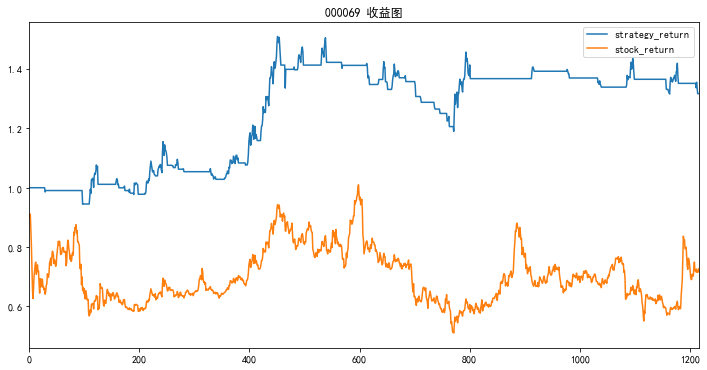

In [29]:
data[['strategy_return', 'stock_return']].plot(figsize = (12,6))
plt.title('000069 收益图')
plt.legend()
#plt.show()

#### 4. 策略改进和优化思考

1. 考虑成交量的配合：在锤子线后面的一根K线如果放量的话，交易信号更可信；    
2. 考虑跟其他形态的结合，例如锤子线后面紧跟着一根大阳线，交易信号更可信；  
3. 考虑和其他技术指标的结合，配合技术指标一起进行条件选股；
4. 考虑对不同类型股票，行业，规模等其他因素进行分组回测，找出策略过去n年内表现更优的股票。
5. 考虑和动量策略以及其他经典策略结合等。